In [21]:
import numpy as np
import random as rd
import tensorflow as tf

from keras.layers import Dense, Embedding, Flatten, Input, concatenate
from keras.models import Model
from keras.optimizers import Adagrad

#Import another jupyter notebook
import import_ipynb
from Productive_CrossValidation_inclTest import *
from Productive_Data_GetTrainTest import samEval

from gensim.models import Doc2Vec, Word2Vec
from gensim.models import KeyedVectors

In [3]:
#for reproducability of the results
seed = 7
np.random.seed(seed)
tf.set_random_seed(seed)
rd.seed(seed)

In [4]:
path = 'data/'
outputpath ='outputs/03_combinations_samEval2018/'

In [5]:
#Load necessary data
train_data, train_labels, test_data, test_labels, word_index, MAX_SEQUENCE_LENGTH = samEval()

## Load an restore textdate

In [6]:
def create_restore_text(index_file, data_file, MAXLEN):
   
    loaded_word_index = {}
    with open(index_file, 'r', encoding='utf-8') as word_index: #Decoding utf-8, else exception
        for line in word_index:
            line = line.rstrip().split("\t")
            loaded_word_index[line[0]] = line[1]  
            
    loaded_data =[]
    with open(data_file, 'r', encoding='utf-8') as data: #Decoding utf-8, else exception
        for line in data:
            line = line.rstrip().split('\n')
            loaded_data.append(line) 
            
    recunstructed_data = []
    for line in loaded_data:
        for string in line:
            tweet = []
            string = string.rstrip().split(',')
            for item in string:
                if item is not ('0'):
                    for key, value in loaded_word_index.items():
                        if value == item:
                            tweet.append(key)
            recunstructed_data.append(tweet)
    return recunstructed_data

In [7]:
train = create_restore_text('output_trainTestData/SamEval_word_index.csv','output_trainTestData/SamEval_train_data.csv', MAX_SEQUENCE_LENGTH)

In [8]:
test = create_restore_text('output_trainTestData/SamEval_word_index.csv','output_trainTestData/SamEval_test_data.csv', MAX_SEQUENCE_LENGTH)

### Embeddings on data set

In [11]:
embeddingbasis = train

for entry in test:
    embeddingbasis.append(entry)
    
cbowmodel_300_3= Word2Vec(embeddingbasis, min_count = 1, size = 300, window = 3)

EMBEDDING_DIM=300

word_vectors_datasat = cbowmodel_300_3.wv

embedding_matrix_dataset = np.zeros((len(word_index)+1, EMBEDDING_DIM))

for word, i in word_index.items():
    try:
        embedding_vector = word_vectors_dataset[word]
        embedding_matrix_dataset[i] = embedding_vector   
    except:
        # words not found in embeddings will be zero
        pass

### Pretrained embeddings on Word2Vec an Glove

In [14]:
def bin_embeddings(file):
    embedding= KeyedVectors.load_word2vec_format(file, binary=True)
    word_vectors_fasttesxt_wiki = embedding.wv
    return word_vectors_fasttesxt_wiki

def txt_embeddings(file):
    embeddings = {}
    with open(file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings[word] = coefs
    return embeddings

def create_eb_matrix(eb_dict, dim):
    EMBEDDING_DIM=dim

    embedding_matrix= np.zeros((len(word_index)+1, EMBEDDING_DIM))

    for word, i in word_index.items():
        try:
            embedding_vector = eb_dict[word]
            embedding_matrix[i] = embedding_vector   
        except:
            # words not found in embeddings will be zero
            pass
    return embedding_matrix

word_vectors_google = bin_embeddings(path+'GoogleNews-vectors-negative300.bin')
word_vectors_glove = txt_embeddings(path+'glove.42B.300d.txt')
EMBEDDING_DIM = 300
embedding_matrix_google = create_eb_matrix(word_vectors_google,EMBEDDING_DIM)
embedding_matrix_glove = create_eb_matrix(word_vectors_glove, EMBEDDING_DIM)

C:\Users\twitter\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
C:\Users\twitter\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until


### Aditional Features

In [15]:
#Load POS data
def get_pos(file):
    pos =[]
    with open(file, 'r') as f:
        for line in f:
            pos.append([int(i) for i in line.split(',')])
    pos= np.asarray(pos)
    return pos

train_pos =get_pos('output_trainTestData/SamEval_train_pos.csv')
test_pos = get_pos('output_trainTestData/SamEval_test_pos.csv')

#Load Sentiment data
def get_sentiment(file):
    senti =[]
    with open(file, 'r') as f:
        for line in f:
            senti.append([float(i) for i in line.split(',')])
    senti= np.asarray(senti)
    return senti

train_senti_blob =get_sentiment('output_trainTestData/SamEval_train_data_sentiment_blob.csv')
test_senti_blob = get_sentiment('output_trainTestData/SamEval_test_data_sentiment_blob.csv')


### Word Embeddings on basis Doc2Vec

In [16]:
doc_embed = Doc2Vec.load(path+'Doc2Vec.model')

word_vectors_doc2vec = doc_embed.wv

EMBEDDING_DIM=300

embedding_matrix_doc2vec = np.zeros((len(word_index)+1, EMBEDDING_DIM))

for word, i in word_index.items():
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix_doc2vec[i] = embedding_vector   
    except:
        # words not found in embeddings will be zero
        pass

C:\Users\twitter\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


# Train the model

In [17]:
NUM_EPOCHS = 30
BATCH_SIZE = 64
optimizer = Adagrad(lr=0.001)
lossfunction = 'binary_crossentropy'
softmax = True

Instructions for updating:
Colocations handled automatically by placer.


## Combine all features

In [24]:
#Embeddings on Dataset
wv_layer_dataset = Embedding(len(word_index)+1,
                 EMBEDDING_DIM,
                 weights=[embedding_matrix_dataset],
                 input_length=MAX_SEQUENCE_LENGTH,
                 trainable=True)

comment_input_dataset = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float32')
embedded_sequences_dataset = wv_layer_dataset(comment_input_dataset)
embedded_sequences_dataset = Flatten()(embedded_sequences_dataset)

#Pretrained Embeddings
wv_layer_google = Embedding(len(word_index)+1,
                 EMBEDDING_DIM,
                 weights=[embedding_matrix_google],
                 input_length=MAX_SEQUENCE_LENGTH,
                 trainable=True)

wv_layer_glove = Embedding(len(word_index)+1,
                 EMBEDDING_DIM,
                 weights=[embedding_matrix_glove],
                 input_length=MAX_SEQUENCE_LENGTH,
                 trainable=True)


comment_input_pretrained = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences_google = wv_layer_google(comment_input_pretrained)
embedded_sequences_google = Flatten()(embedded_sequences_google)
embedded_sequences_glove = wv_layer_glove(comment_input_pretrained)
embedded_sequences_glove = Flatten()(embedded_sequences_glove)

#Additional Features
input_blob = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float32')
input_pos = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float32')

#Word embedding on basis Doc2Vec
wv_layer_doc2vec = Embedding(len(word_index)+1,
                 EMBEDDING_DIM,
                 weights=[embedding_matrix_doc2vec],
                 input_length=MAX_SEQUENCE_LENGTH,
                 trainable=True)

comment_input_doc2vec = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float32')
embedded_sequences_doc2vec = wv_layer_doc2vec(comment_input_doc2vec)
embedded_sequences_doc2vec = Flatten ()(embedded_sequences_doc2vec)

#Concatenate inputs 
x = concatenate([embedded_sequences_dataset,embedded_sequences_google, embedded_sequences_glove, 
                 input_blob, input_pos, embedded_sequences_doc2vec])

#Dense Layer
x = Dense(600, activation='relu')(x)

#Output (Dense) Layer
preds = Dense(2, activation='softmax')(x)

# build the model
model = Model(inputs=[comment_input_dataset,comment_input_pretrained,input_blob, input_pos, comment_input_doc2vec ], outputs=preds)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           (None, 40)           0                                            
__________________________________________________________________________________________________
input_23 (InputLayer)           (None, 40)           0                                            
__________________________________________________________________________________________________
input_26 (InputLayer)           (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_18 (Embedding)        (None, 40, 300)      4118700     input_22[0][0]                   
__________________________________________________________________________________________________
embedding_

Instructions for updating:
Use tf.cast instead.


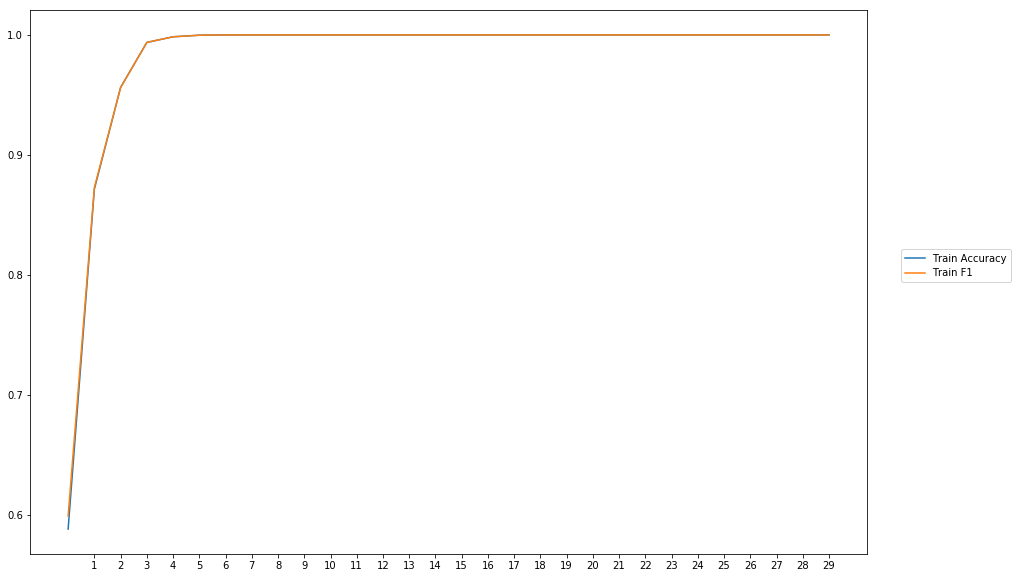


-----Test Scores----
Loss: 1.08135529926845
Accuracy: 64.66836734693877
Precision: 54.33673468001614
Recall: 68.4887459586853
F1: 60.5974345939475


In [28]:
train_evaluate_fife_inputs(model, NUM_EPOCHS, BATCH_SIZE, optimizer, lossfunction, train_data, train_data, train_pos, train_senti_blob, train_data, train_labels, test_data, test_data, test_pos, test_senti_blob, test_data, test_labels, softmax, outputpath, 'combineall')

## Combine all features use seperate models

In [44]:
#Embeddings on Dataset
wv_layer_dataset_4 = Embedding(len(word_index)+1,
                 EMBEDDING_DIM,
                 weights=[embedding_matrix_dataset],
                 input_length=MAX_SEQUENCE_LENGTH,
                 trainable=True)

comment_input_dataset_4 = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float32')
embedded_sequences_dataset_4 = wv_layer_dataset_4(comment_input_dataset_4)
x_dataset_4 = Dense(600, activation='relu')(embedded_sequences_dataset_4)
x_dataset_4 = Flatten()(x_dataset_4)

#Pretrained Embeddings
wv_layer_google_4 = Embedding(len(word_index)+1,
                 EMBEDDING_DIM,
                 weights=[embedding_matrix_google],
                 input_length=MAX_SEQUENCE_LENGTH,
                 trainable=True)
comment_input_google_4 = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences_google_4 = wv_layer_google(comment_input_google_4)
x_google_4 = Dense(600, activation ='relu') (embedded_sequences_google_4)
x_google_4 = Flatten()(x_google_4)

wv_layer_glove_4 = Embedding(len(word_index)+1,
                 EMBEDDING_DIM,
                 weights=[embedding_matrix_glove],
                 input_length=MAX_SEQUENCE_LENGTH,
                 trainable=True)
comment_input_glove_4 = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences_glove_4 = wv_layer_glove_4(comment_input_glove_4)
x_glove_4 = Dense(600, activation='relu')(embedded_sequences_glove_4)
x_glove_4 = Flatten()(x_glove_4)

#Additional Features
input_blob_4 = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float32')
x_blob_4 = Dense(600, activation='relu')(input_blob_4) 

input_pos_4 = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float32')
x_pos_4 = Dense(600, activation='relu')(input_pos_4) 

#Word embedding on basis Doc2Vec
wv_layer_doc2vec_4 = Embedding(len(word_index)+1,
                 EMBEDDING_DIM,
                 weights=[embedding_matrix_doc2vec],
                 input_length=MAX_SEQUENCE_LENGTH,
                 trainable=True)

comment_input_doc2vec_4 = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float32')
embedded_sequences_doc2vec_4 = wv_layer_doc2vec_4(comment_input_doc2vec_4)
x_doc2vec_4 = Dense(600, activation='relu')(embedded_sequences_doc2vec_4)
x_doc2vec_4= Flatten ()(x_doc2vec_4)

#Concatenate inputs 
x_4 = concatenate([x_dataset_4,x_google_4,x_glove_4, x_blob_4,x_pos_4,x_doc2vec_4])

#Output (Dense) Layer
preds_4 = Dense(2, activation='softmax')(x_4)

# build the model
model_4 = Model(inputs=[comment_input_dataset_4,comment_input_google_4,comment_input_glove_4,input_blob_4,input_pos_4,comment_input_doc2vec_4 ], outputs=preds_4)

model_4.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_60 (InputLayer)           (None, 40)           0                                            
__________________________________________________________________________________________________
input_61 (InputLayer)           (None, 40)           0                                            
__________________________________________________________________________________________________
input_62 (InputLayer)           (None, 40)           0                                            
__________________________________________________________________________________________________
input_65 (InputLayer)           (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_

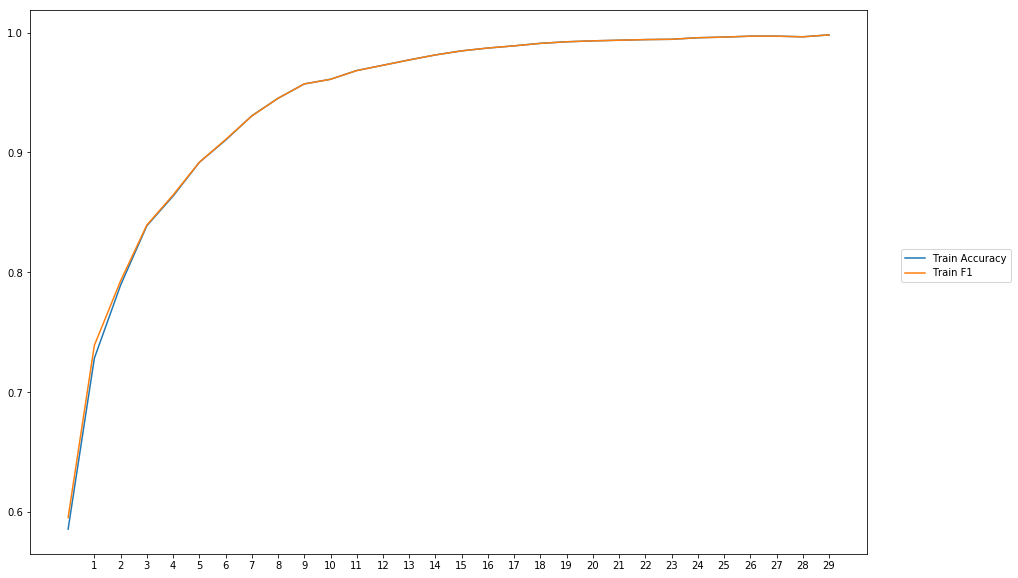


-----Test Scores----
Loss: 0.6984541525646132
Accuracy: 67.3469387755102
Precision: 57.45257451017546
Recall: 68.16720255042856
F1: 62.35293619450732


In [46]:
train_evaluate_six_inputs(model_4, NUM_EPOCHS, BATCH_SIZE, optimizer, lossfunction, train_data, train_data, train_data, train_senti_blob,train_pos, train_data, train_labels, test_data, test_data, test_data, test_senti_blob, test_pos, test_data, test_labels, softmax, outputpath, 'combineall_seperatmodels')

In [45]:
#model = Kearas model
#softmax = boolean, true if the model uses softmaxe in the output layer otherwise false
#outputpath = path were the output csv should be stored
#outputname = name to use for the output csv
def train_evaluate_six_inputs(model, nrepochs, nrbatch, optimizer, lossfunction, train_data, train_data2, 
                               train_data3, train_data4,train_data5, train_data6, train_labels, test_data, test_data2, 
                               test_data3, test_data4, test_data5, test_data6, test_labels, softmax, outputpath, outputname):
    import datetime
    
    seed = 7
    np.random.seed(seed)
    tf.set_random_seed(seed)
    rd.seed(seed)
    
    #needed for softmax-activation
    if softmax:
        labelstrain = to_categorical(train_labels)
        labelstest = to_categorical(test_labels)
    else:
        labelstrain = train_labels
        labelstest = test_labels

    time_callback = TimeHistory() 
    
    #evaluate the positive class (=ironic data)
    precision =km.binary_precision(label=1)
    recall = km.binary_recall(label=1)
    f1 = km.f1_score(label=1)

    model.compile(loss = lossfunction,
          optimizer=optimizer,
          metrics=['accuracy', precision, recall, f1])

    #Train the model 
    hist= model.fit([train_data, train_data2, train_data3, train_data4, train_data5, train_data6], labelstrain, epochs=nrepochs, batch_size=nrbatch, 
                    shuffle=True, verbose = 0, callbacks=[time_callback])

    from matplotlib import pyplot
    %matplotlib inline
    pyplot.figure(figsize=(15,10))
    pyplot.plot(hist.history['acc']) 
    pyplot.plot(hist.history['f1_score'])
    #pyplot.plot(hist.history['loss'])
    pyplot.xticks(np.arange(1,nrepochs))
    pyplot.legend(['Train Accuracy', 'Train F1', 'Validation Accuracy', 'Validation F1', 'Loss'], loc=(1.04,0.5))
    pyplot.show()

    #Store the keras model
    model.save(outputpath+str(datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))+'_'+outputname+
                   '_'+'_model.h5')        
    
    score = model.evaluate([test_data,test_data2, test_data3, test_data4, test_data5, test_data6], labelstest, verbose = 0)
    
    print("\n-----Test Scores----")
    print("Loss: " + str(score[0]))
    print("Accuracy: " + str(score[1]*100))
    print("Precision: " + str(score[2]*100))
    print("Recall: " + str(score[3]*100))
    print("F1: " + str(score[4]*100))


    #stores the test results        
    f= open(outputpath+str(datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))+' '+outputname+'_finaltestresults.csv','w+')
    f.write('Loss;'+str(score[0])+'\n'+
            'Accuracy;'+str(score[1])+'\n'+
            'Precision;'+str(score[2])+'\n'+
            'Recall;'+str(score[3])+'\n'+
            'F1;'+str(score[4])+'\n')
    f.close() 

## Combine only pretrained Word2Vec and GloVe embeddings with additional Features

In [29]:
#Pretrained Embeddings
wv_layer_google_2 = Embedding(len(word_index)+1,
                 EMBEDDING_DIM,
                 weights=[embedding_matrix_google],
                 input_length=MAX_SEQUENCE_LENGTH,
                 trainable=True)

wv_layer_glove_2 = Embedding(len(word_index)+1,
                 EMBEDDING_DIM,
                 weights=[embedding_matrix_glove],
                 input_length=MAX_SEQUENCE_LENGTH,
                 trainable=True)


comment_input_pretrained_2 = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences_google_2 = wv_layer_google(comment_input_pretrained_2)
embedded_sequences_google_2 = Flatten()(embedded_sequences_google_2)
embedded_sequences_glove_2 = wv_layer_glove(comment_input_pretrained_2)
embedded_sequences_glove_2 = Flatten()(embedded_sequences_glove_2)

#Additional Features
input_blob_2 = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float32')
input_pos_2 = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float32')


#Concatenate inputs 
x_2 = concatenate([embedded_sequences_google_2, embedded_sequences_glove_2, 
                 input_blob_2, input_pos_2])

#Dense Layer
x_2 = Dense(600, activation='relu')(x_2)

#Output (Dense) Layer
preds_2 = Dense(2, activation='softmax')(x_2)

#build the model
model_2 = Model(inputs=[comment_input_pretrained_2,input_blob_2, input_pos_2], outputs=preds_2)

model_2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_19 (Embedding)        (None, 40, 300)      4118700     input_27[0][0]                   
__________________________________________________________________________________________________
embedding_20 (Embedding)        (None, 40, 300)      4118700     input_27[0][0]                   
__________________________________________________________________________________________________
flatten_5 (Flatten)             (None, 12000)        0           embedding_19[1][0]               
__________________________________________________________________________________________________
flatten_6 

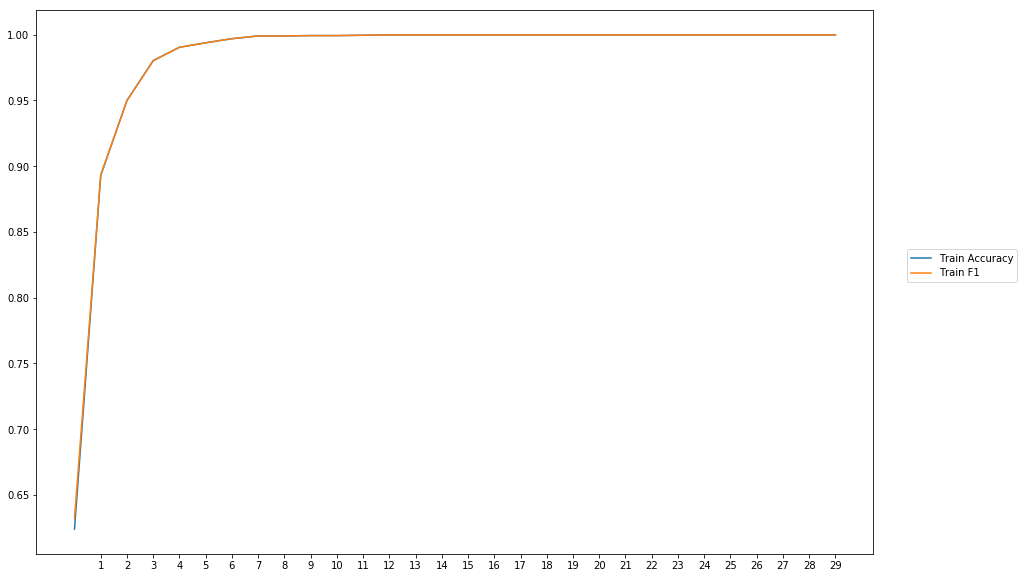


-----Test Scores----
Loss: 1.0760117817898185
Accuracy: 62.244897959183675
Precision: 52.02156332829608
Recall: 62.05787779355053
F1: 56.59823549131029


In [31]:
train_evaluate_three_inputs(model_2, NUM_EPOCHS, BATCH_SIZE, optimizer, lossfunction, train_data, train_pos, train_senti_blob, train_labels, test_data, test_pos, test_senti_blob, test_labels, softmax, outputpath, 'combinePretrainedAndAdditionalFeatures')

## Combine only pretrained embedding an additional features as seperate models

In [36]:
#Pretrained Embeddings
# Word2Vec
wv_layer_google_3 = Embedding(len(word_index)+1,
                 EMBEDDING_DIM,
                 weights=[embedding_matrix_google],
                 input_length=MAX_SEQUENCE_LENGTH,
                 trainable=True)
comment_input_google = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences_google_3 = wv_layer_google_3(comment_input_google)
x_google = Dense(600, activation='relu')(embedded_sequences_google_3)
x_google = Flatten() (x_google)

#GloVe
wv_layer_glove_3 = Embedding(len(word_index)+1,
                 EMBEDDING_DIM,
                 weights=[embedding_matrix_glove],
                 input_length=MAX_SEQUENCE_LENGTH,
                 trainable=True)
comment_input_glove = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences_glove_3 = wv_layer_glove_3(comment_input_glove)
x_glove = Dense(600, activation='relu')(embedded_sequences_glove_3)
x_glove = Flatten()(x_glove)

#Additional Features
input_pos_3 = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float32')
x_pos =  Dense(600, activation='relu')(input_pos_3)

input_blob_3 = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float32')
x_blob = Dense(600, activation='relu')(input_blob_3)


#Concatenate inputs 
x_3 = concatenate([x_google, x_glove, x_pos, x_blob])

#Dense Layer
x_3 = Dense(600, activation='relu')(x_3)

#Output (Dense) Layer
preds_3 = Dense(2, activation='softmax')(x_3)

#build the model
model_3 = Model(inputs=[comment_input_google,comment_input_glove,input_pos_3,input_blob_3], outputs=preds_3)

model_3.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_39 (InputLayer)           (None, 40)           0                                            
__________________________________________________________________________________________________
input_40 (InputLayer)           (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_31 (Embedding)        (None, 40, 300)      4118700     input_39[0][0]                   
__________________________________________________________________________________________________
embedding_32 (Embedding)        (None, 40, 300)      4118700     input_40[0][0]                   
__________________________________________________________________________________________________
dense_14 (

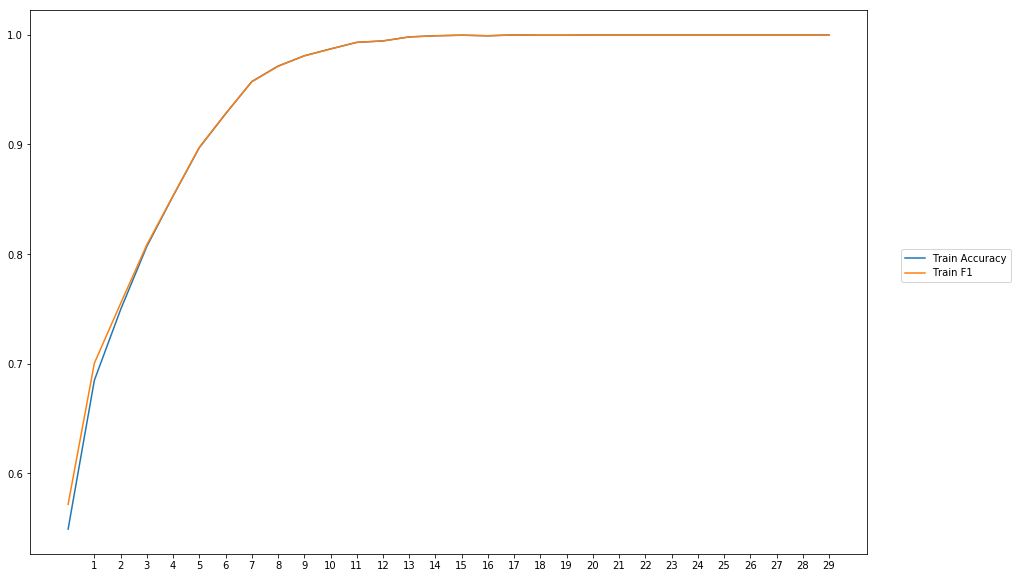


-----Test Scores----
Loss: 1.08107768272867
Accuracy: 66.58163265306123
Precision: 56.60377356964859
Recall: 67.52411573391508
F1: 61.58357273325004


In [37]:
train_evaluate_four_inputs(model_3, NUM_EPOCHS, BATCH_SIZE, optimizer, lossfunction, train_data, train_data, train_pos, train_senti_blob, train_labels, test_data, test_data, test_pos, test_senti_blob, test_labels, softmax, outputpath, 'combinePretrainedAndAdditionalFeatures_seperate')